In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as mp


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')





Mounted at /content/gdrive


In [8]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [9]:

import io
data = io.BytesIO(uploaded['this_is_classified.csv'])    

In [10]:
import pandas as pd   
df = pd.read_csv('/content/this_is_classified.csv')
#df.sheet_names
df.head()


,timestamp,tweet_text,username,all_hashtags,followers_count,Tweet_punct,clean_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Tweet_stemmed,scores,compound,comp_score
0,2021-10-23 16:21:09+00:00,b'@hcetamd @cathyyoung63 all i gonna say is th...,b'districtyoder',[],541,bhcetamd cathyyoung all i gonna say is this sc...,all i gonna say is this scenario where a ...,"['', 'all', 'i', 'gonna', 'say', 'is', 'this',...","['', 'gonna', 'say', 'scenario', 'guy', 'dress...","['', 'gonna', 'say', 'scenario', 'guy', 'dress...","['', 'gonna', 'say', 'scenario', 'guy', 'dress...","{'neg': 0.159, 'neu': 0.693, 'pos': 0.147, 'co...",-0.4019,0
1,2021-10-23 16:21:08+00:00,b'@brxckhxmptn i should maintain journalistic ...,b'french_dispatch',[],23258,bbrxckhxmptn i should maintain journalistic ne...,i should maintain journalistic neutrality ...,"['', 'i', 'should', 'maintain', 'journalistic'...","['', 'maintain', 'journalistic', 'neutrality',...","['', 'maintain', 'journalistic', 'neutrality',...","['', 'maintain', 'journalist', 'neutral', 'l',...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
2,2021-10-23 16:21:06+00:00,b'#joebiden #whitehouse #usa #climate #vaccina...,b'timeisfinishing',"['joebiden', 'whitehouse', 'usa', 'climate', '...",2211,bjoebiden whitehouse usa climate vaccination c...,35a aims of the papacy xc2 xa0 libe...,"['', '35a', 'aims', 'of', 'the', 'papacy', 'xc...","['', '35a', 'aims', 'papacy', 'xc2', 'xa0', 'l...","['', '35a', 'aim', 'papacy', 'xc2', 'xa0', 'li...","['', '35a', 'aim', 'papaci', 'xc2', 'xa0', 'li...","{'neg': 0.122, 'neu': 0.571, 'pos': 0.306, 'co...",0.6705,1
3,2021-10-23 16:21:05+00:00,b'@the_ns @margaretatwood can you provide an e...,b'redtache',[],882,bthens margaretatwood can you provide an examp...,can you provide an example of a marginalised...,"['', 'can', 'you', 'provide', 'an', 'example',...","['', 'provide', 'example', 'marginalised', 'gr...","['', 'provide', 'example', 'marginalised', 'gr...","['', 'provid', 'exampl', 'marginalis', 'group'...","{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...",0.5853,1
4,2021-10-23 16:21:05+00:00,b'@bmott001 @blashford @davidjonesmp @davidjon...,b'stoghill',[],95,bbmott blashford davidjonesmp davidjonesmp sha...,shame on you for failing to protect the en...,"['', 'shame', 'on', 'you', 'for', 'failing', '...","['', 'shame', 'failing', 'protect', 'environme...","['', 'shame', 'failing', 'protect', 'environme...","['', 'shame', 'fail', 'protect', 'environ', 'f...","{'neg': 0.193, 'neu': 0.572, 'pos': 0.235, 'co...",0.1027,1


In [11]:
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional  #different layers of bilstm model
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences  #transforms into 2d array of shape
from keras.models import Sequential  #for semantically useful names,1 input tensor and 1 output tensor
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)
## Check function
x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
x_test_sample = ["I’m creating a macro and need some text for testing purposes", "I’m designing a document and don’t want to get bogged down in what the text actually says"]
X_train_Glove_s, X_test_Glove_s, word_index_s, embeddings_dict_s = prepare_model_input(x_train_sample, x_test_sample, 100, 20)
print("\n X_train_Glove_s \n ", X_train_Glove_s)
print("\n X_test_Glove_s \n ", X_test_Glove_s)
print("\n Word index of the word testing is : ", word_index_s["testing"])
print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 51 unique tokens.
(4, 20)
Total 259746 word vectors.

 X_train_Glove_s 
  [[ 0  0  0  0  0  0  0  0  8  9  5 10 11  2  6  3 12  4 13 14]
 [17 18 19  1 20 21 22 23 24  3 25 26  6  1 27 28 29 30 31 32]]

 X_test_Glove_s 
  [[ 0  0  0  0  0  0  0  0  0  7 33  1 34  4 35 36  2 37 38 39]
 [ 0  0  0  7 40  1 41  4 42 43 44 45 46 47 48 49  3  2 50 51]]

 Word index of the word testing is :  38

 Embedding for thw word want 
 
 [ 0.13627  -0.054478  0.3703   -0.41574   0.60568  -0.42729  -0.50151
  0.35923  -0.49154   0.21827  -0.15193   0.52536  -0.24206   0.023875
  0.8225    1.089     0.98825  -0.17803   0.77806  -1.0647   -0.28742
  0.50458   0.21612   0.65681   0.34295  -2.1084   -0.82557  -0.31966
  0.87567  -1.0679    3.3802    1.2084   -1.272    -0.15921  -0.25237
 -0.2696   -0.18756  -0.35523   0.084172 -0.56539  -0.24081   0.15926
  0.3287    0.54591   0.29897   0.18948  -0.57113   0.17399  -0.19338
  0.51921 ]


In [13]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequebtial model
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [14]:
X = df['clean_tweet']
y = df['comp_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 15125 unique tokens.
(6208, 500)
Total 259746 word vectors.
Done!
Building Model!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           756300    
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
        

In [15]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [16]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=128,
                           verbose=1)   #epochs is for extracting the input from our dataset and running it through the model
                           #verbose shows animated version of epochs being run

Epoch 1/5
39/39 [==============================] - 240s 6s/step - loss: 0.6737 - accuracy: 0.5890 - val_loss: 0.6685 - val_accuracy: 0.6135
Epoch 2/5
39/39 [==============================] - 220s 6s/step - loss: 0.6049 - accuracy: 0.6744 - val_loss: 0.5537 - val_accuracy: 0.7158
Epoch 3/5
39/39 [==============================] - 220s 6s/step - loss: 0.5107 - accuracy: 0.7600 - val_loss: 0.5170 - val_accuracy: 0.7424
Epoch 4/5
39/39 [==============================] - 220s 6s/step - loss: 0.4357 - accuracy: 0.8137 - val_loss: 0.4837 - val_accuracy: 0.7681
Epoch 5/5
39/39 [==============================] - 221s 6s/step - loss: 0.3528 - accuracy: 0.8556 - val_loss: 0.4985 - val_accuracy: 0.7858


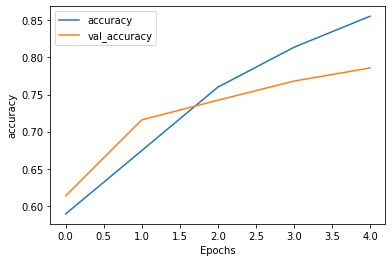

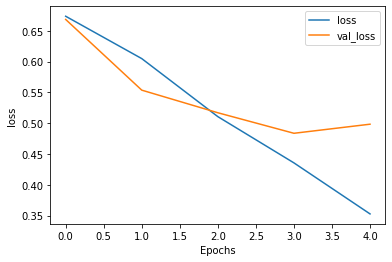

In [17]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')


In [20]:
print("\n Evaluating Model ... \n")
predict_x=model.predict(X_test_Glove) 
classes_x=np.argmax(predict_x,axis=1)

print(metrics.classification_report(y_test, classes_x))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, classes_x)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 



INFO:logger:  mcc = 0.5625558431747654
INFO:logger:  true positive = 580
INFO:logger:  true negative = 396
INFO:logger:  false positive = 144
INFO:logger:  false negative = 122
INFO:logger:  pricision = 0.8011049723756906
INFO:logger:  recall = 0.8262108262108262
INFO:logger:  F1 = 0.8134642356241234
INFO:logger:  accuracy = 0.785829307568438


              precision    recall  f1-score   support

           0       0.76      0.73      0.75       540
           1       0.80      0.83      0.81       702

    accuracy                           0.79      1242
   macro avg       0.78      0.78      0.78      1242
weighted avg       0.79      0.79      0.79      1242



